In [1]:
# basics + plotting
import os, sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 250
plt.rcParams["font.family"] = "sans serif"

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler

# custom
PROJECT_PATH = '/n/groups/marks/databases/ukbiobank/users/ralphest/mit6.8610-project'
sys.path.insert(1, PROJECT_PATH)

from utils import (
    data_utils, 
    eval_utils, 
    plotting_utils, 
    train_test_utils,
    constants
)

from models import (
    mlp
)

In [3]:
d = {i:torch.randint(10, size=(32, 100)) for i in range(5)}

In [ ]:
d.

In [12]:
torch.stack(list(d.values())).shape

torch.Size([5, 32, 100])

In [42]:
def sumab(a,b, c=1):
    return a + b + c

In [43]:
k = {'a':1, 'c':2, 'b':1}

In [44]:
sumab(**k)

4

In [17]:
len(embs.shape)

3

In [18]:
inds = torch.randint(10, size=(32, 100))

In [25]:
inds = inds.unsqueeze(-1)

In [27]:
torch.cat([embs, inds], dim = -1).shape

torch.Size([32, 100, 6])

In [5]:
embs = torch.randint(10, size=(32, 100, 5))
ws = torch.randint(10, size=(32, 100, 1))

In [11]:
(embs * ws).sum(1).shape

torch.Size([32, 5])

In [2]:
constants.model_to_embed_dim

{'esm2_t6_8M_UR50D': 320,
 'esm2_t12_35M_UR50D': 480,
 'esm2_t33_650M_UR50D': 1280,
 'esm1v_t33_650M_UR90S_1': 1280}

In [160]:
import importlib
mlp = importlib.reload(mlp)
data_utils = importlib.reload(data_utils)
eval_utils = importlib.reload(eval_utils)

In [161]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [162]:
data = data_utils.load_variation_dataset("../data/data/", 
                                         "../gene_list.txt", 
                                         ["seq-var-matrix"], 
                                         "../data/phenotypes_hcm_only.parquet",
                                         predict = ["hcm"], low_memory=False)

Fetching FHL1 data ... Done
Fetching ACTC1 data ... Done
Fetching ACTN2 data ... Done
Fetching CSRP3 data ... Done
Fetching MYBPC3 data ... Done
Fetching MYH6 data ... Done
Fetching MYH7 data ... Done
Fetching MYL2 data ... Done
Fetching MYL3 data ... Done
Fetching MYOZ2 data ... Done
Fetching LDB3 data ... Done
Fetching TCAP data ... Done
Fetching TNNC1 data ... Done
Fetching TNNI3 data ... Done
Fetching TNNT2 data ... Done
Fetching TPM1 data ... Done
Fetching TRIM63 data ... Done
Fetching PLN data ... Done
Fetching JPH2 data ... Done
Fetching FLNC data ... Done
Fetching ALPK3 data ... Done
Fetching LMNA data ... Done
Fetching NEXN data ... Done
Fetching VCL data ... Done
Fetching MYOM2 data ... Done
Fetching CASQ2 data ... Done
Fetching CAV3 data ... Done
Fetching MYLK2 data ... Done
Fetching CRYAB data ... Done
Combining tables ... Done
Integrating with phenotypes data ...Done


In [163]:
data.filter_variants_by_ac(3, 2000)

In [164]:
train_dataset, test_dataset = data.train_test_split(balance_on=['hcm','ethnicity'])

In [189]:
def train_epoch(model, train_loader, optimizer, loss_fn, log_every=10):
    model.train()
    total_loss = 0
    
    all_labels, all_preds = [],[]
    for i, batch in enumerate(train_loader):
        # move batch dictionary to device
        data_utils.batch_dict_to_device(batch, device)
        labels, features = batch['labels'], batch['seq-var-matrix']
        
        # compute prediction and loss
        preds = model(features)
        loss = loss_fn(preds, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # tracking
        total_loss += loss.item()
        all_labels.append(labels.cpu())
        all_preds.append(preds.flatten().detach().cpu())
        
        # logging
        if (i % log_every == 0):
            print(f"\tBatch {i} | BCE Loss: {loss.item():.4f}")
    
    
    
    metrics = eval_utils.get_metrics(torch.cat(all_labels), 
                                     torch.cat(all_preds))
    metrics['loss'] = total_loss
    
    return metrics

def test(model, test_loader, loss_fn):
    model.eval()
    total_loss = 0
    all_labels, all_preds = [],[]
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            # move batch dictionary to device
            data_utils.batch_dict_to_device(batch, device)
            labels, features = batch['labels'], batch['seq-var-matrix']

            # compute prediction and loss
            preds = model(features)
            loss = loss_fn(preds, labels)

            # tracking
            total_loss += loss.item()
            
            all_labels.append(labels.cpu())
            all_preds.append(preds.flatten().cpu())
    
    all_labels, all_preds = torch.cat(all_labels), torch.cat(all_preds)
    metrics = eval_utils.get_metrics(all_labels, 
                                     all_preds)
    metrics['loss'] = total_loss
    
    return metrics, all_labels, all_preds

def train(model, 
          train_dataset,
          test_dataset, 
          lr=1e-3, 
          n_epochs=10,
          batch_size=256):
    
    train_loader = DataLoader(
        dataset = train_dataset, 
        batch_size = batch_size,
        sampler = WeightedRandomSampler(train_dataset.weights('hcm', 
                                                              flatten_factor=1), 
                                        num_samples = len(train_dataset)),
        num_workers=12
    )

    test_loader = DataLoader(
        dataset = test_dataset,
        batch_size = batch_size,
        num_workers=12
    )
    
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    
    track_metrics = {'train':{i:None for i in range(n_epochs)}, 
                     'test': {i:None for i in range(n_epochs)}}
    
    for epoch in range(n_epochs):
        print(f"Epoch #{epoch}:")
        train_metrics = train_epoch(model, 
                                    train_loader, 
                                    optimizer, 
                                    loss_fn, 
                                    log_every=20)
        print("Train metrics:")
        eval_utils.print_metrics(train_metrics)
        test_metrics = test(model, 
                            test_loader, 
                            loss_fn)
        print("Test metrics:")
        eval_utils.print_metrics(test_metrics)
        
        track_metrics['train'][epoch] = train_metrics
        track_metrics['test'][epoch] = test_metrics
    
    return track_metrics
    

In [169]:
params = json.load(open("../params/mlp.json"))
params['model_params']['in_dim'] = train_dataset[0]['seq-var-matrix'].shape[0]
model = mlp.MLP(**params['model_params'])


In [170]:
model


MLP(
  (fc): Sequential(
    (0): Linear(in_features=5663, out_features=1, bias=True)
  )
)

In [171]:
model_metrics = train(model, 
                      train_dataset,
                      test_dataset, 
                      lr=1e-3, 
                      n_epochs=20,
                      batch_size=256)

Epoch #0:
	Batch 0 | BCE Loss: 0.6930
	Batch 20 | BCE Loss: 0.6925
	Batch 40 | BCE Loss: 0.6918
	Batch 60 | BCE Loss: 0.6908
	Batch 80 | BCE Loss: 0.6896
	Batch 100 | BCE Loss: 0.6896
	Batch 120 | BCE Loss: 0.6891
	Batch 140 | BCE Loss: 0.6901
	Batch 160 | BCE Loss: 0.6863
	Batch 180 | BCE Loss: 0.6886
	Batch 200 | BCE Loss: 0.6856
	Batch 220 | BCE Loss: 0.6839
	Batch 240 | BCE Loss: 0.6832
	Batch 260 | BCE Loss: 0.6816
	Batch 280 | BCE Loss: 0.6836
	Batch 300 | BCE Loss: 0.6803
	Batch 320 | BCE Loss: 0.6843
	Batch 340 | BCE Loss: 0.6819
	Batch 360 | BCE Loss: 0.6808
	Batch 380 | BCE Loss: 0.6796
	Batch 400 | BCE Loss: 0.6809
	Batch 420 | BCE Loss: 0.6804
	Batch 440 | BCE Loss: 0.6781
	Batch 460 | BCE Loss: 0.6760
	Batch 480 | BCE Loss: 0.6729
	Batch 500 | BCE Loss: 0.6721
	Batch 520 | BCE Loss: 0.6785
	Batch 540 | BCE Loss: 0.6778
	Batch 560 | BCE Loss: 0.6751
	Batch 580 | BCE Loss: 0.6706
	Batch 600 | BCE Loss: 0.6737
	Batch 620 | BCE Loss: 0.6754
	Batch 640 | BCE Loss: 0.6682
	Batch

In [214]:
test_loader = DataLoader(
        dataset = train_dataset,
        batch_size = 256,
        num_workers=12
)

In [215]:
loss_fn = nn.BCEWithLogitsLoss()

In [216]:
mt, labels, preds = test(model, test_loader, loss_fn)

In [237]:
vs, idxs = preds.sort(descending=True)

In [238]:
labels.flatten()[idxs]

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [247]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(labels.flatten(), preds)


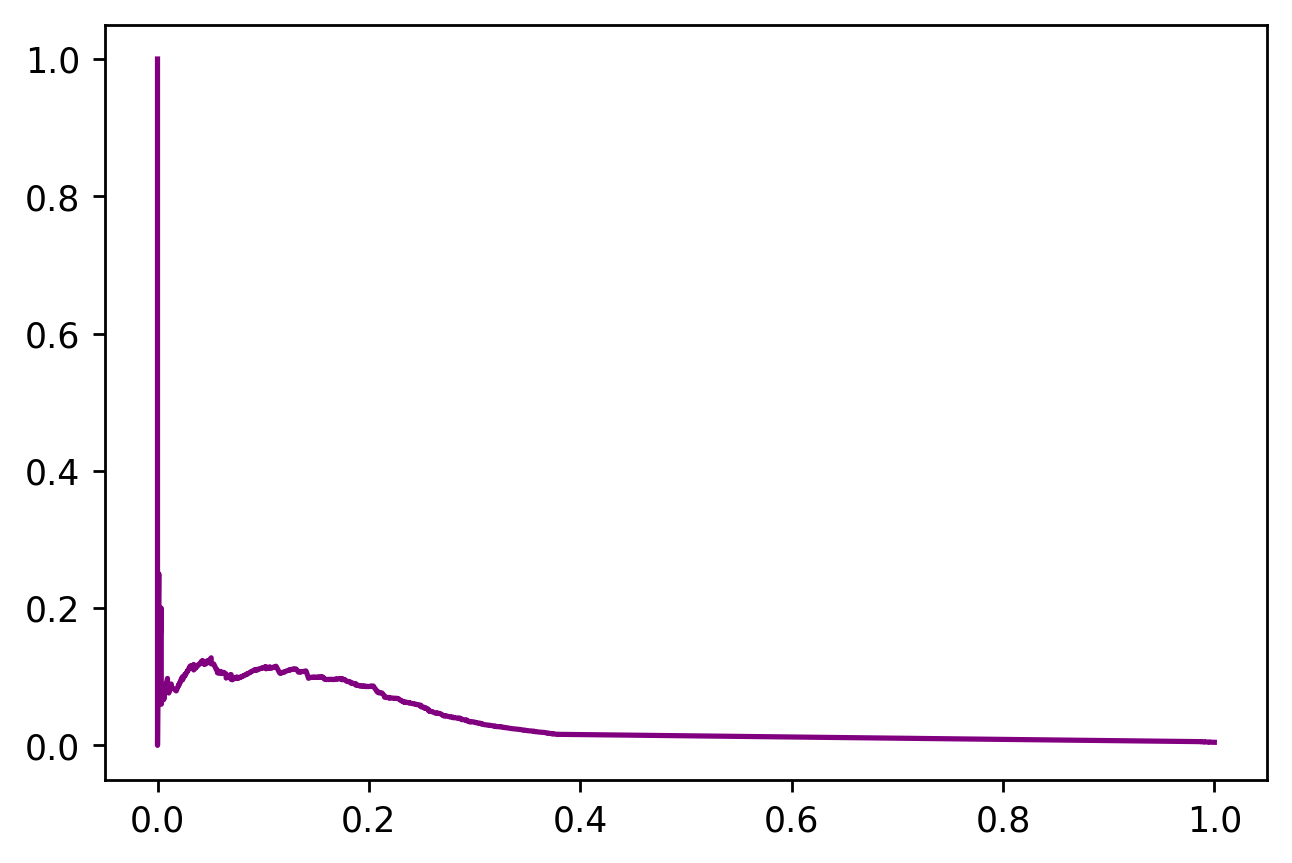

In [250]:
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

In [ ]:
def plot_metrics(results, axes, metrics = ['accuracy', 'precision', 'recall', 'f1', 'AUROC', 'loss']):
    for mt,ax in zip(metrics, axes.flatten()):
        ax.plot([x[mt] for x in results['train'].values()])
        ax.plot([x[mt] for x in results['test'].values()])
        ax.set_title(mt)
    axes[0,0].legend(['train', 'test'])

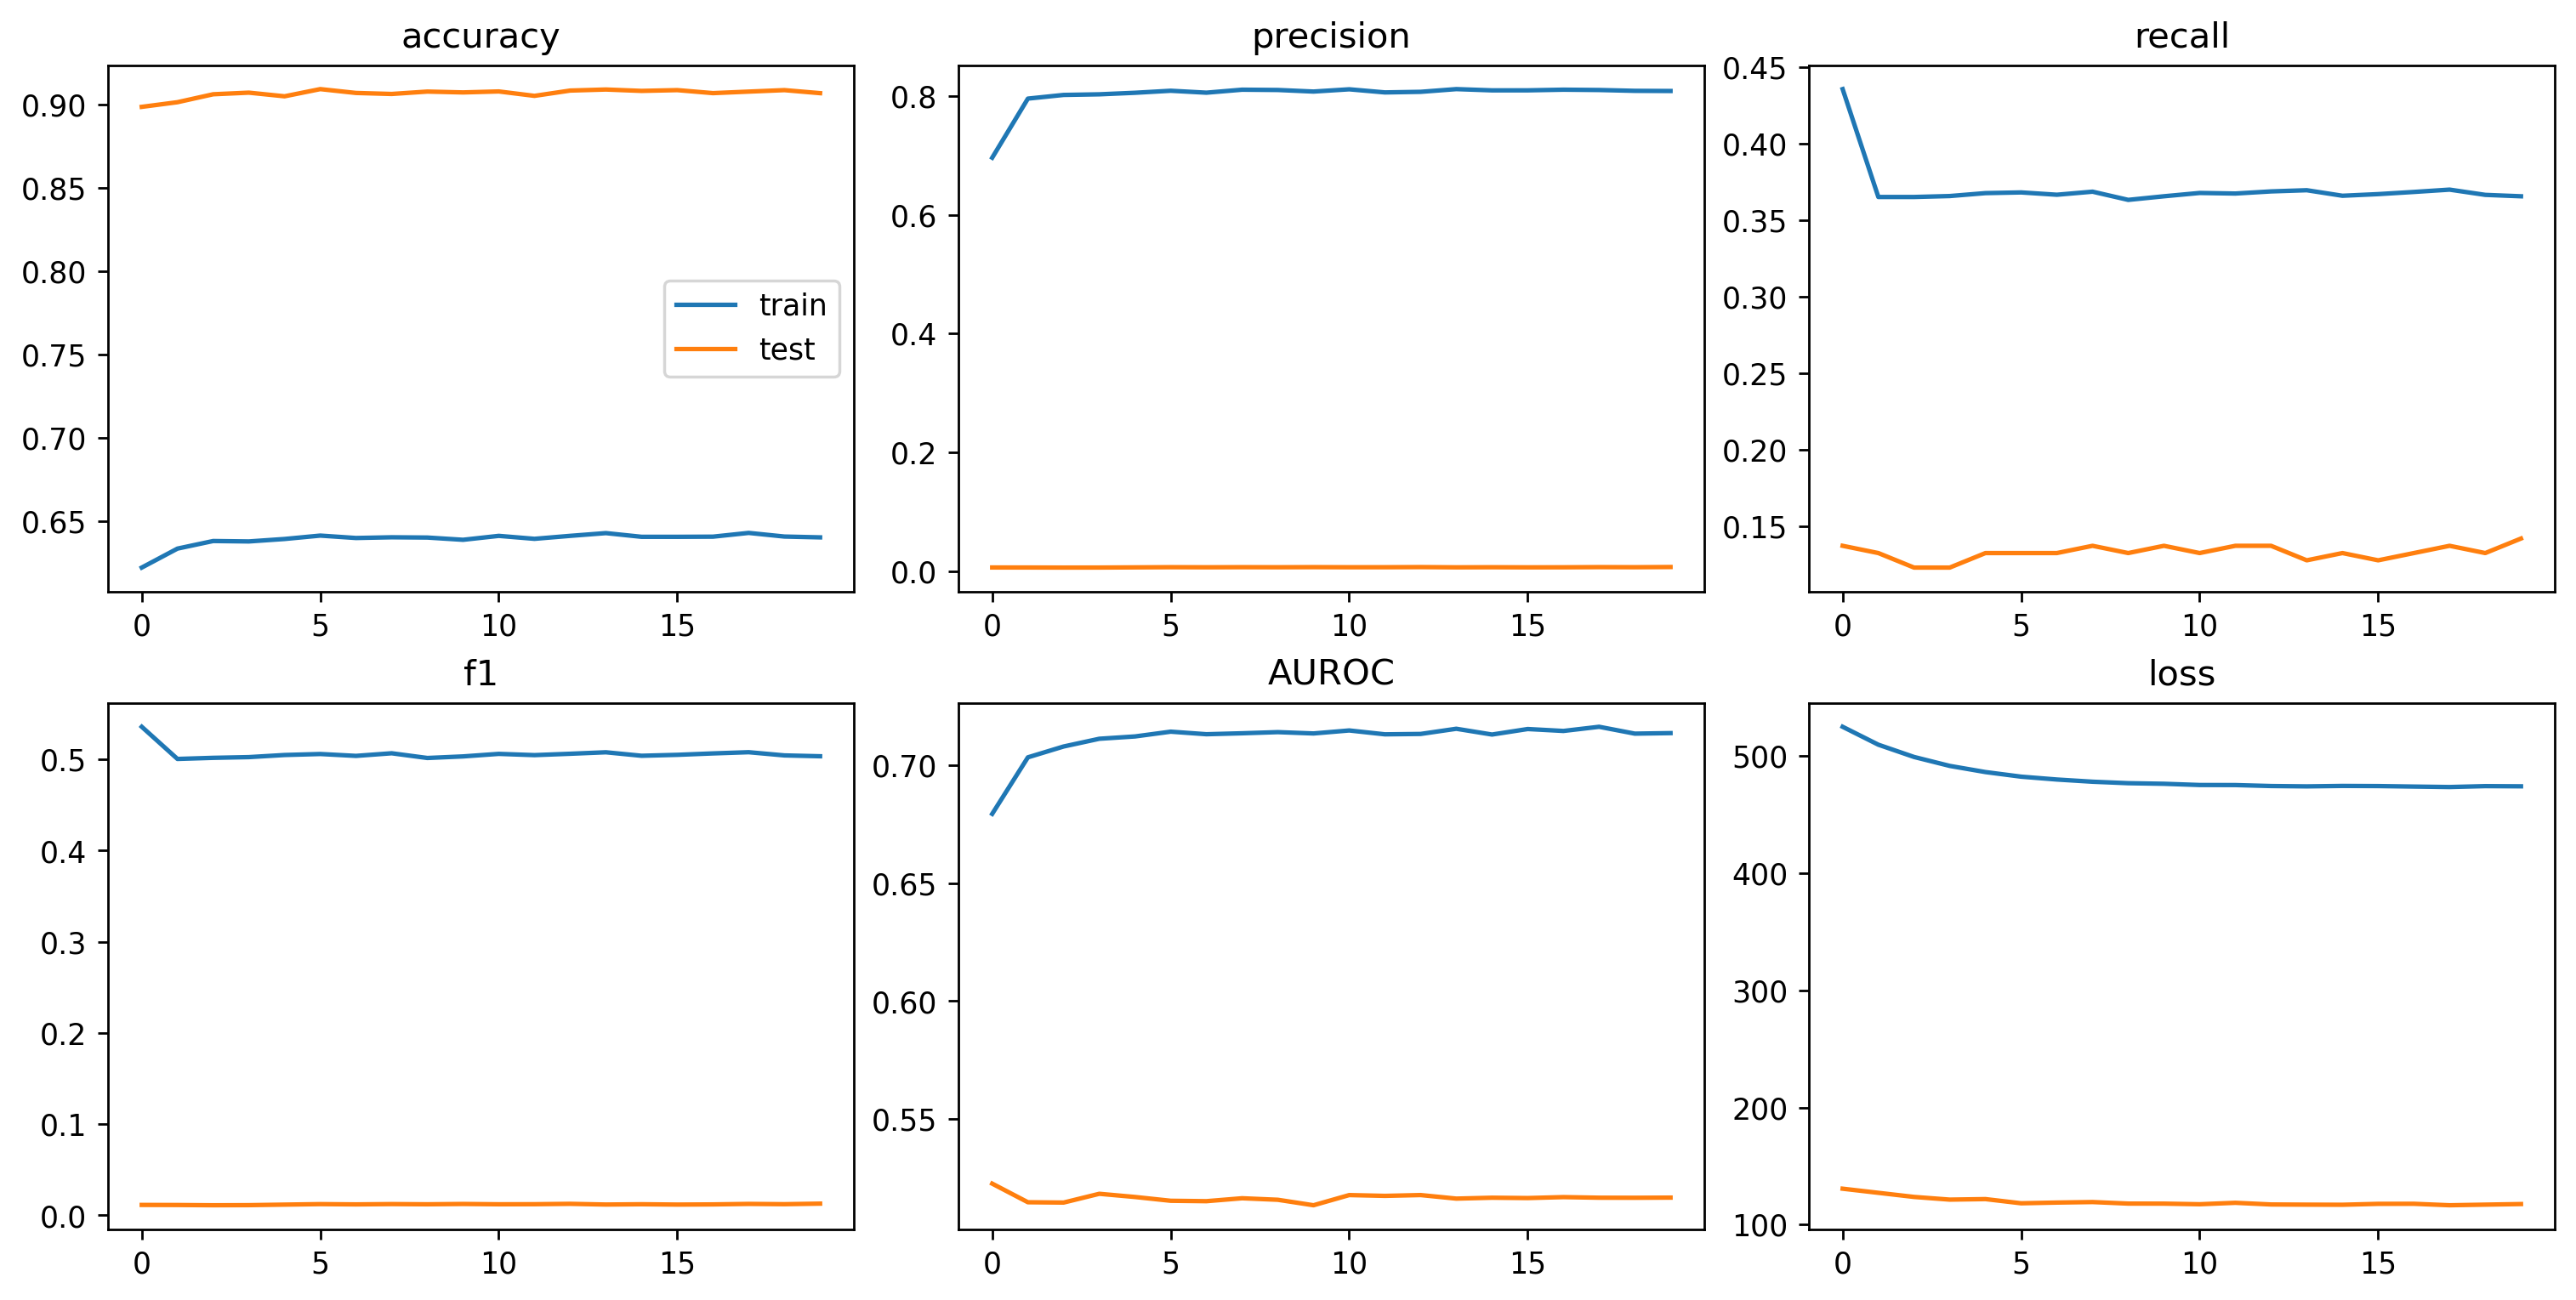

In [178]:
fig, axes = plt.subplots(2,3,figsize=(12,6), constrained_layout=True)

plot_metrics(model_metrics, axes)

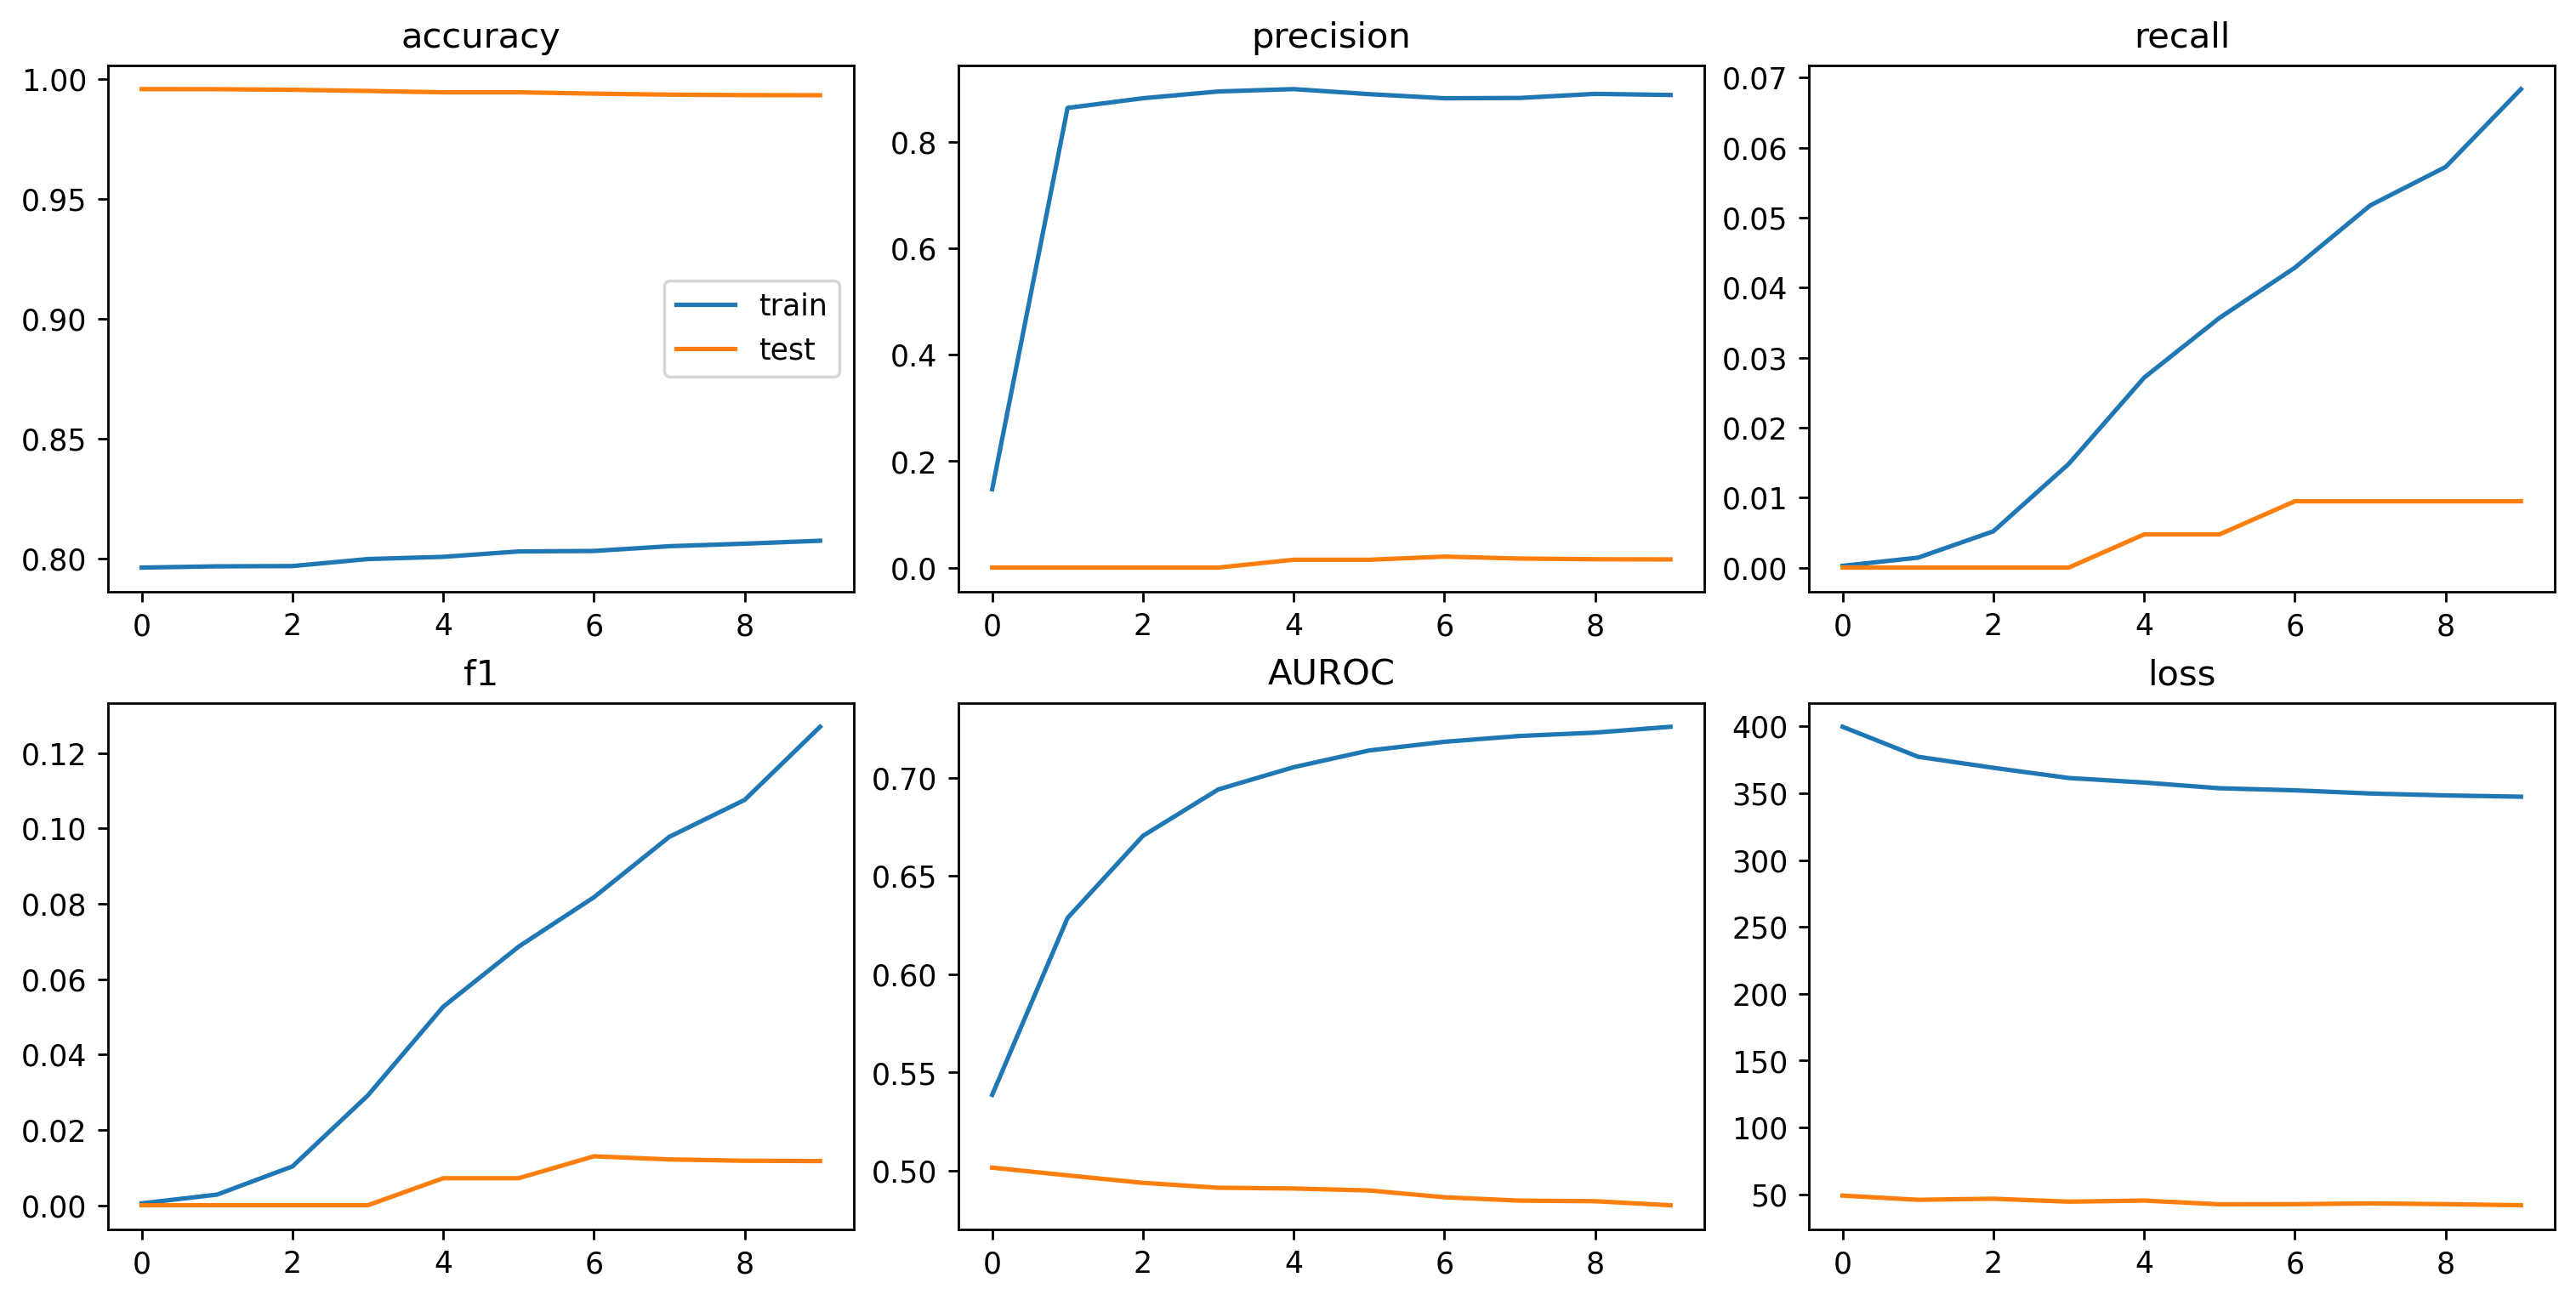

In [ ]:
fig, axes = plt.subplots(2,3,figsize=(12,6), constrained_layout=True)

plot_metrics(model_metrics, axes)
# fig.savefig('../figures/mlp_simple_flatten_factor=1.png')

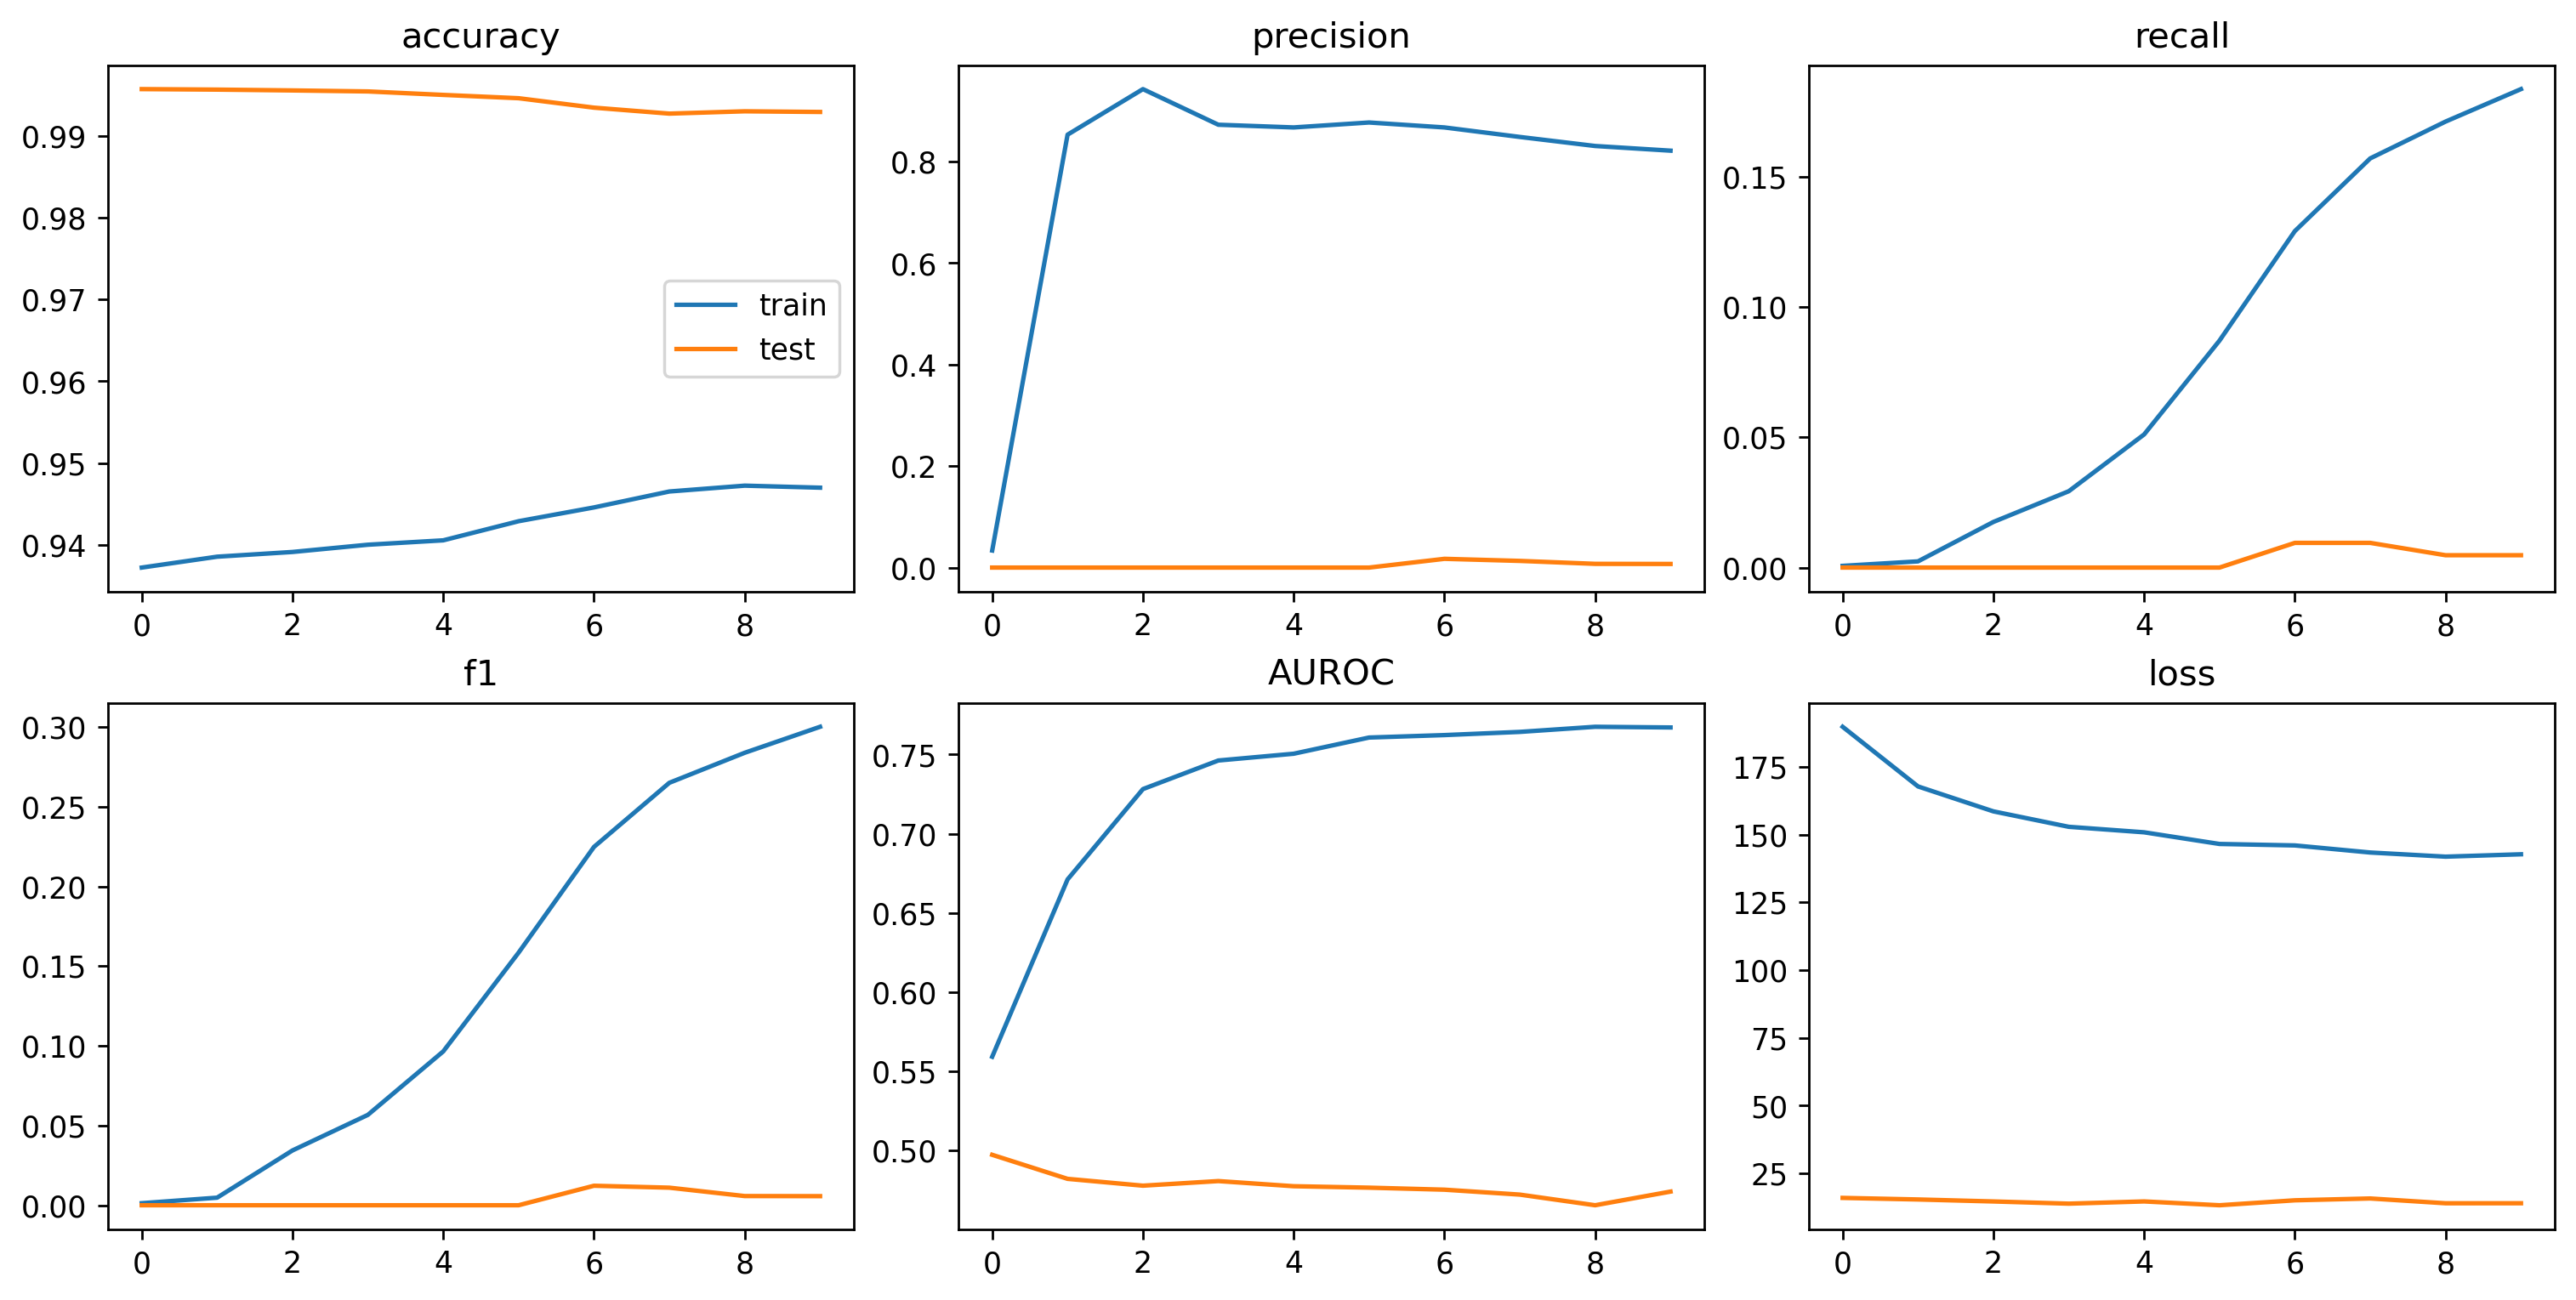

In [16]:
fig, axes = plt.subplots(2,3,figsize=(12,6), constrained_layout=True)

plot_metrics(model_metrics, axes)
fig.savefig('../figures/lr_initial.png')